In [1]:
import numpy as np
import pandas as pd

from scipy import signal
from scipy import integrate
from scipy import fftpack

import matplotlib.pyplot as plt

from utils import *

# plt.style.use('seaborn-pastel')

## Simulación de edificio de 4 pisos como masas puntuales con rigideces intermedias

In [2]:
# Edificio de 4 pisos de 20 toneladas cada uno, con rigideces laterales de 57MN/m entre si
k = 57e6 # N/m
m = 20e3 # kg

k1, k2, k3, k4 = k, k, k, k
m1, m2, m3, m4 = m, m, m, m

# Matrices de rigidez y de masa
K = np.array([[k1+k2, -k2, 0, 0],
             [-k2, k2+k3, -k3, 0],
             [0, -k3, k3+k4, -k4],
             [0, 0, -k4, k4]])

M = np.diag((m1, m2, m3, m4))

print("K:")
printMatrix(K)
print("M:")
printMatrix(M)

K:
1.14E+08 -5.70E+07 0.00E+00 0.00E+00 
-5.70E+07 1.14E+08 -5.70E+07 0.00E+00 
0.00E+00 -5.70E+07 1.14E+08 -5.70E+07 
0.00E+00 0.00E+00 -5.70E+07 5.70E+07 
M:
2.00E+04 0.00E+00 0.00E+00 0.00E+00 
0.00E+00 2.00E+04 0.00E+00 0.00E+00 
0.00E+00 0.00E+00 2.00E+04 0.00E+00 
0.00E+00 0.00E+00 0.00E+00 2.00E+04 


In [3]:
# Resolución por autovectores y autovalores
A = np.linalg.inv(M)@K
lamb, eigv = np.linalg.eig(A)
lamb = np.flip(lamb) # menor a mayor
eigv = np.flip(eigv, axis=1)

In [4]:
# Frecuencias modales
w_modes = np.sqrt(lamb)
f_modes = w_modes/2/np.pi
print(('f = {}').format(np.round(f_modes,3)))

f = [ 2.951  8.497 13.017 15.968]


In [5]:
# Matriz de formas modales
print("Formas modales:")
printMatrix(eigv)

Formas modales:
2.28E-01 -5.77E-01 6.57E-01 4.29E-01 
4.29E-01 -5.77E-01 -2.28E-01 -6.57E-01 
5.77E-01 4.89E-17 -5.77E-01 5.77E-01 
6.57E-01 5.77E-01 4.29E-01 -2.28E-01 


In [6]:
# Matriz de masas modales
M_modal = np.transpose(eigv)@M@eigv
M_modal[M_modal<1e-3] = np.nan
print("Masas modales:")
printMatrix(M_modal)

Masas modales:
2.00E+04 NAN NAN NAN 
NAN 2.00E+04 NAN NAN 
NAN NAN 2.00E+04 NAN 
NAN NAN NAN 2.00E+04 


In [7]:
# Matriz de rigideces modales
K_modal = np.transpose(eigv)@K@eigv
K_modal[K_modal<1e-3] = np.nan
print("Rigideces modales:")
printMatrix(K_modal)

Rigideces modales:
6.88E+06 NAN NAN NAN 
NAN 5.70E+07 NAN NAN 
NAN NAN 1.34E+08 NAN 
NAN NAN NAN 2.01E+08 


In [8]:
# Verificación de la la validez de las matrices,
# obteniendo las fercuencias modales nuevamente, 
# ahora como w_i = sqrt(k_i/m_i)
w_2 = np.zeros(len(w_modes))
for mode in range(len(w_2)):
    w_2[mode] = np.sqrt(K_modal[mode,mode]/M_modal[mode,mode])
f_2 = w_2/np.pi/2
print(('f_2 = {}').format(np.round(f_2, 3)))

f_2 = [ 2.951  8.497 13.017 15.968]


In [9]:
# Normalización de vectores modales
eigv_norm = np.zeros(eigv.shape)
for mode in range(len(w_modes)):
    eigv_norm[:,mode] = eigv[:,mode]/max(abs(eigv[:,mode]))

Max value off diagonal: 0.000


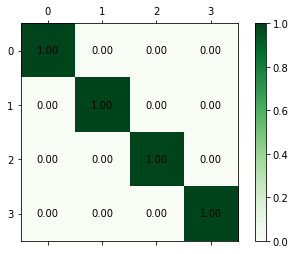

In [10]:
# MAC teórico
MAC_theo = get_MAC_matrix(eigv_norm, eigv_norm)
plot_MAC(MAC_theo, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(get_max_off_diagonal(MAC_theo)))

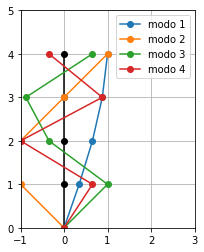

In [11]:
# Gráfico de modos
plot_modes(eigv_norm)

## Simulación de aceleración con perfil de ruido blanco

In [12]:
# Aceleración maxima en funcion del tiempo
def max_accel(t,t_end):
    a = 0.5*(1-np.cos(2*np.pi*t/t_end))
    return a

In [13]:
# Simulación de aceleracion en forma de ruido blanco bajo la curva de aceleracion maxima
t_end = 600
delta_t = 1/119
t = np.linspace(0, t_end, int(t_end/delta_t))

R = 0.1*np.random.normal(size=len(t)) # Vector de ruido gaussiano
R_mean = np.mean(R)

accel = (R - R_mean)*max_accel(t,t_end) # Aceleración escalada con ruido
max_accel_vec = max_accel(t,t_end) # Vector con aceleraciones puras

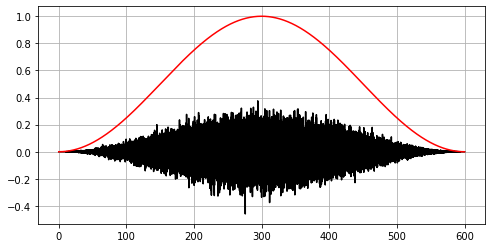

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
fig.add_axes()
ax.plot(t, accel, color='k', marker='')
ax.plot(t, max_accel_vec, color='r')
ax.grid(True, markevery=1)

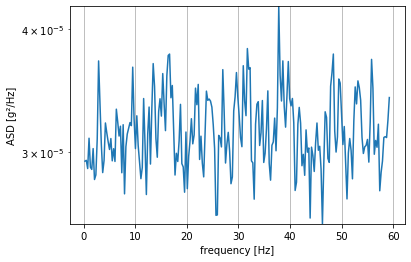

In [15]:
# PSD de aceleraciones en la base
nperseg=450
freq, psd = signal.welch(accel, 
                      fs=1./(delta_t), # sample rate
                      window='hamming', # apply a Hanning window before taking the DFT
                      nperseg=nperseg, # compute periodograms of 256-long segments of x
                      noverlap=nperseg//2,
                      detrend='constant',
                      return_onesided=False) #'constant') # detrend x by subtracting the mean)

plt.figure()
plt.semilogy(freq[1:len(psd)//2], psd[1:len(psd)//2])
plt.ylim([np.min(psd[1:]), np.max(psd[1:])])
plt.xlabel('frequency [Hz]')
plt.ylabel('ASD [g²/Hz]')
plt.grid()
plt.show()

In [16]:
psd_mean = np.mean(psd)
max_freq = np.max(freq)
print('ASD promedio: {:.1g} g²/Hz'.format(psd_mean))
print('Grms para ASD constante = ASD*f_max = {:.3f} g_rms'.format(psd_mean*max_freq))

ASD promedio: 3e-05 g²/Hz
Grms para ASD constante = ASD*f_max = 0.002 g_rms


In [17]:
# calculo de g_rms por integracion
area = integrate.simps(psd, freq)
g_rms = np.sqrt(area)
print('Grms = {:.3f} g_rms'.format(g_rms))

Grms = nan g_rms


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Espectro de aceleraciones [g/Hz]')

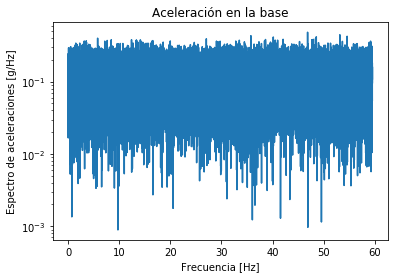

In [18]:
# Transformada de Fourier de aceleraciones en la base
Ug_fft = np.fft.fft(accel) * delta_t
Ug_fft_freq = np.fft.fftfreq(t.shape[-1], d=delta_t)

plt.figure()
plt.semilogy(Ug_fft_freq[:len(Ug_fft_freq)//2], abs(Ug_fft[:len(Ug_fft_freq)//2]))
plt.title('Aceleración en la base')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Espectro de aceleraciones [g/Hz]')

## Simulación de respuesta dinámica del edificio a ruido blanco su base

In [19]:
xi = 0.025 # fracción de amortiguamiento crítico
Xi = xi*np.ones(eigv_norm.shape[1])
r = np.array([1, 1, 1, 1]).reshape(4,1) # vector logico de desplazamientos respecto de la base
print('xi = {}'.format(Xi[:]))
print('r = {}^T'.format(r[:,0]))

xi = [0.025 0.025 0.025 0.025]
r = [1 1 1 1]^T


La solucion del espectro de desplazamientos para cada modo es
<br/>
<center> $Y(\omega) = \frac{\frac{\iota}{m_i} U_g(\omega)}{\omega_i^2 - \omega^2 + 2i \xi_i \omega_i \omega}$ </center>
<br/>
con
<center> $\iota = \Phi^T M r$. </center>
<br/>
Y la aceleración es
<center> $\ddot{Y}(\omega) = \omega^2 Y(\omega)$ </center>

In [20]:
U_g = np.copy(Ug_fft)
w = 2*np.pi*Ug_fft_freq
f = w/2/np.pi

In [21]:
I = np.transpose(eigv)@M@r
print(I)
m_modal = M_modal.diagonal() 
Y = np.zeros((len(w), len(w_modes)), dtype=complex)
ddotY = np.copy(Y) 
for mode in range(Y.shape[1]):
    C = I[mode] / (m_modal[mode]*(w_modes[mode]**2 - w**2 + 2*1j*Xi[mode]*w_modes[mode]*w))
    Y[:,mode] = C*Ug_fft
    ddotY[:,mode] = -(w**2)*Y[:,mode]

[[ 37808.54546412]
 [-11547.00538379]
 [  5593.99754118]
 [  2426.46822844]]


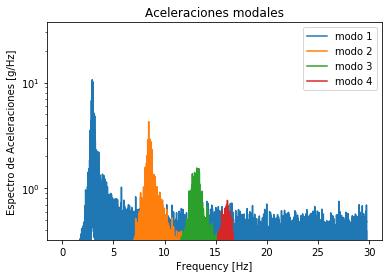

10.620443312888815


In [22]:
plt.figure()
lgnd  = ['modo {}'.format(mode+1) for mode in range(Y.shape[1])]
plt.semilogy(f[:len(f)//4], abs(ddotY[:len(f)//4]))
plt.title('Aceleraciones modales')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Espectro de Aceleraciones [g/Hz]')
plt.ylim([abs(ddotY[len(f)//4, 0]), None])
plt.legend(lgnd)
plt.show()
print(np.max(abs(ddotY)))

In [23]:
freq_max = [abs(f[i]) for i in ddotY.argmax(axis=0)]
print(('freqs from max response = {}').format(np.round(freq_max, 3)))
print('errors in % = {}'.format(np.round(100*(f_modes - freq_max) / f_modes, 2)))

freqs from max response = [ 2.932  8.45  13.145 16.147]
errors in % = [ 0.65  0.55 -0.98 -1.12]


### Respuesta en cada piso

In [24]:
# Espectro de respuesta en frecuencia
X = np.copy(Y)
X = (eigv @ Y.T).T # Desplazamientos en los grados de libertad
ddotX = -(w**2 * X.T).T # Aceleraciones

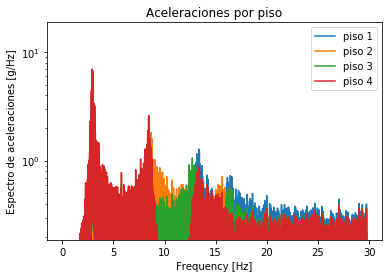

In [25]:
plt.figure()
lgnd  = ['piso {}'.format(mode+1) for mode in range(X.shape[1])]
plt.semilogy(f[:len(f)//4], abs(ddotX[:len(f)//4,:]))
plt.title('Aceleraciones por piso')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Espectro de aceleraciones [g/Hz]')
plt.ylim([abs(ddotX[len(f)//4, 0]), None])
plt.legend(lgnd)
plt.show()

## Peak-picking (PP)

In [26]:
ddotX_psd = np.copy(ddotX)
for piso in range(X.shape[1]):
    ddotX_psd[:, piso] = ddotX[:, piso] * np.conj(ddotX[:, piso])

In [27]:
# Average Normalized PSD (ANPSD)
ANPSD = np.zeros(ddotX_psd.shape[0], dtype=complex)
NPSD = np.copy(ddotX_psd)
for piso in range(ddotX.shape[1]):
    NPSD[:, piso] = ddotX_psd[:, piso] / np.sum(ddotX_psd[:, piso])
ANPSD = np.sum(NPSD, axis=1)
mode_ind_pp = np.array([m for m in signal.argrelmax(ANPSD[:len(f)//4], order=1000)]).flatten()

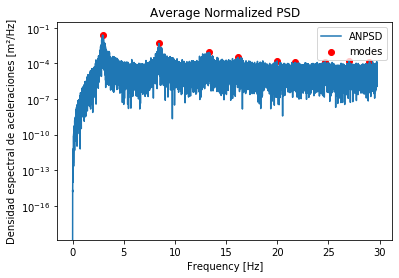

In [28]:
plt.figure()
plt.semilogy(f[:len(f)//4], abs(ANPSD[:len(f)//4]), label='ANPSD')
plt.scatter(f[mode_ind_pp], abs(ANPSD[mode_ind_pp]), label='modes', color='r')
plt.title('Average Normalized PSD')
# plt.ylim([abs(ANPSD[len(f)//4]), None])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Densidad espectral de aceleraciones [m²/Hz]')
plt.legend()
plt.show()

In [29]:
f_pp = f[mode_ind_pp[:4]]
err_f_pp = (f_pp - f_modes)/f_modes*100
mode_num = np.array([1, 2, 3, 4])

data = np.vstack((mode_num, f_modes, f_pp)).T
headers = ['Modo', 'Teoría [Hz]', 'Peak-picking [Hz]']
print_modes_dataframe(data=data, headers=headers, decimals=2)

,Modo,Teoría [Hz],Peak-picking [Hz]
0,1,2.95,2.93
1,2,8.50,8.45
2,3,13.02,13.35
3,4,15.97,16.15


### Formas modales

In [30]:
modes_pp = np.copy(eigv) 
for mode in range(modes_pp.shape[1]):
    idx = mode_ind_pp[mode]
    for dof in range(X.shape[1]):
        cross_power = ddotX[idx, dof] * np.conj(ddotX[idx, 0])
        ang = abs(np.angle(cross_power, deg=True))
        if 0 <= ang <= 60:
            sign = 1
        elif 120 <= ang <=180:
            sign = -1
        else:
            sign = 0
        modes_pp[dof, mode] = sign * abs(ddotX[idx, dof]) / abs(ddotX[idx, 0])
        
# Normalizacion
for col in range(modes_pp.shape[1]):
    modes_pp[:,col] = modes_pp[:,col]/max(abs(modes_pp[:,col]))

Max value off diagonal: 0.554


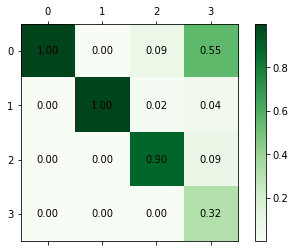

In [31]:
MAC_pp = get_MAC_matrix(eigv_norm, modes_pp)
plot_MAC(MAC_pp, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(get_max_off_diagonal(MAC_pp)))

## Frequency Domain Decomposition (FDD)

In [32]:
# Respuesta en el tiempo
ddotX_time = fftpack.ifft(ddotX, axis=0) # Obtengo respuestas en el tiempo mediante transformada inversa

# Matriz de densidades espectrales cruzadas de la respuesta.
csd_nperseg = 1024
S_xx = np.zeros((csd_nperseg, ddotX_time.shape[1], ddotX_time.shape[1]), dtype=complex)
for piso1 in range(ddotX.shape[1]):
    for piso2 in range (ddotX.shape[1]):
        f_S, S_xx[:, piso1, piso2] = signal.csd(ddotX_time[:, piso1], ddotX_time[:, piso2],
                                               fs=1./(delta_t),
                                               window='hanning',
                                               nperseg=csd_nperseg,
                                               detrend='constant',
                                               axis=0,
                                               return_onesided=False)

In [33]:
# Extraigo frecuencias y formas de modo por SVD
u, s, vh = np.linalg.svd(S_xx)
    
# Maximos del primer valor singular
mode_ind_fdd = np.array([m for m in signal.argrelmax(s[:, 0], order=12)]).flatten()

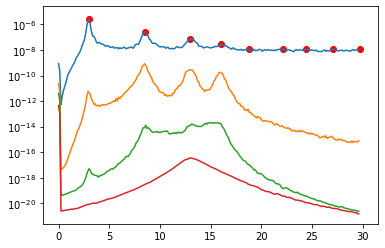

In [34]:
plt.semilogy(f_S[:len(f_S)//4], s[:len(f_S)//4, :])
# plt.ylim([s[len(f_S)//4, 0], None])
plt.scatter(f_S[mode_ind_fdd[:len(mode_ind_fdd)//4]],
            abs(s[mode_ind_fdd[:len(mode_ind_fdd)//4], 0]),
            color='r')

In [35]:
f_fdd = f_S[mode_ind_fdd[:4]]
err_f_fdd = (f_fdd - f_modes)/f_modes*100

data = np.vstack((mode_num, f_modes, f_fdd)).T
headers = ['Modo', 'Teoría [Hz]', 'FDD [Hz]']
print_modes_dataframe(data=data, headers=headers, decimals=2)

,Modo,Teoría [Hz],FDD [Hz]
0,1,2.95,3.02
1,2,8.50,8.48
2,3,13.02,13.02
3,4,15.97,16.04


In [36]:
# Formas modales
modes_fdd = np.zeros(eigv.shape, dtype=complex)
for idx in range(modes_fdd.shape[1]):
    modes_fdd[:, idx] = u[mode_ind_fdd[idx], :, 0]

# Normalización
for col in range(modes_fdd.shape[1]):
    modes_fdd[:,col] = modes_fdd[:,col]/max(abs(modes_fdd[:,col]))

Max value off diagonal: 0.353


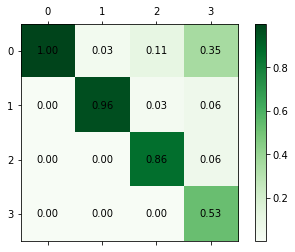

In [37]:
MAC_fdd = get_MAC_matrix(eigv_norm, modes_fdd)
plot_MAC(MAC_fdd, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(get_max_off_diagonal(MAC_fdd)))

## Enhanced Frequency Domain Decomposition (EFDD)

### Identificación de las PSD modales 

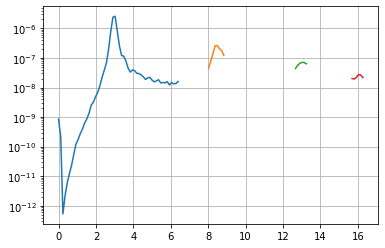

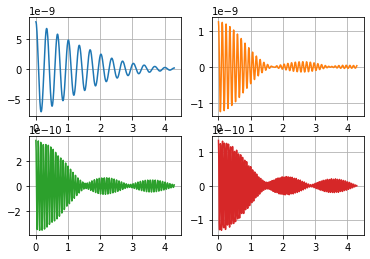

In [38]:
mac_th = 0.9
total_mode_num = modes_fdd.shape[0]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:total_mode_num]
sdof_psd = np.zeros_like(s, dtype=complex)
sdof_acf = np.zeros_like(s, dtype=complex)
t_sdof_acf = np.linspace(0, sdof_psd.shape[0]*delta_t, sdof_psd.shape[0])

fig_psd, ax_psd = plt.subplots()
fig_decay, ax_decay = plt.subplots(total_mode_num//2, 2)
ax_psd.grid(True, markevery=1)
[ax_decay.flat[i].grid(True, markevery=1) for i in range(len(ax_decay.flat))]

for mode in range(total_mode_num):
    peak_idx = mode_ind_fdd[mode]
    idx_low, idx_high = get_efdd_segment(u, peak_idx, mac_th)
  
    ax_psd.semilogy(f_S[idx_low:idx_high], abs(s[idx_low:idx_high, 0]), color=colors[mode])
    
    sdof_psd[idx_low:idx_high, mode] = s[idx_low:idx_high, 0]
    sdof_acf[:, mode] = fftpack.ifft(sdof_psd[:, mode])
    ax_decay.flat[mode].plot(t_sdof_acf[:len(t_sdof_acf)//2],
                             sdof_acf[:len(t_sdof_acf)//2, mode].real, color=colors[mode])

### Estimación de los amortiguamientos

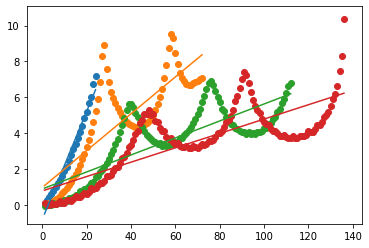

In [39]:
xi_efdd = np.zeros(total_mode_num)
R2 = np.zeros(total_mode_num)

for mode in range(total_mode_num):
    decay = sdof_acf[:, mode].real[:len(t_sdof_acf)//2]
    xi_efdd[mode], R2[mode] = get_damp_from_decay(decay)

In [40]:
data = np.vstack((mode_num, Xi, xi_efdd)).T
headers = ['Modo', 'Teoría', 'EFDD']
print_modes_dataframe(data=data, headers=headers, decimals=3)

,Modo,Teoría,EFDD
0,1,0.025,0.048
1,2,0.025,0.016
2,3,0.025,0.008
3,4,0.025,0.006


### Estimación de las frecuencias

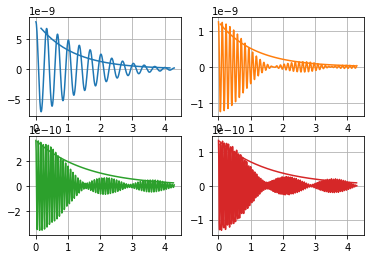

In [41]:
f_efdd = np.zeros(total_mode_num)

fig_decay, ax_decay = plt.subplots(total_mode_num//2, 2)
[ax_decay.flat[i].grid(True, markevery=1) for i in range(len(ax_decay.flat))]

for mode in range(total_mode_num):
    decay = sdof_acf[:, mode].real[:len(t_sdof_acf)//2]
    f_efdd_damped = get_freq_from_signal(t_sdof_acf, sdof_acf[:, mode])
    f_efdd[mode] = f_efdd_damped / np.sqrt(1-xi_efdd[mode]**2)
    w_n_efdd = 2*np.pi*f_efdd[mode]
    peak_ind = np.array([m for m in signal.argrelmax(abs(decay), order=1)]).flatten()

    ax_decay.flat[mode].plot(t_sdof_acf[:len(sdof_acf)//2], decay, color=colors[mode])
    ax_decay.flat[mode].plot(t_sdof_acf[peak_ind],
                             decay[0]*np.exp(-xi_efdd[mode]*w_n_efdd*t_sdof_acf[peak_ind]),
                             color=colors[mode])

In [42]:
err_f_efdd = (f_efdd - f_modes)/f_modes*100

data = np.vstack((mode_num, f_modes, f_fdd, f_efdd)).T
headers = ['Modo', 'Teoría [Hz]', 'FDD [Hz]', 'EFDD [Hz]']
print_modes_dataframe(data=data, headers=headers, decimals=2)

,Modo,Teoría [Hz],FDD [Hz],EFDD [Hz]
0,1,2.95,3.02,3.05
1,2,8.50,8.48,8.67
2,3,13.02,13.02,13.29
3,4,15.97,16.04,16.00


## Curve-fit Frequency Domain Decomposition (CFDD)

### Estimación mediante modelo ARX

#### Construcción de medio espectro positivo de la PSD modal

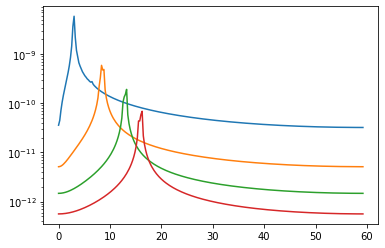

In [43]:
d_t = t_sdof_acf[1] - t_sdof_acf[0]
f_P = np.fft.fftfreq(len(t_sdof_acf)//2, d=d_t)

P = np.zeros((len(t_sdof_acf)//2, total_mode_num), dtype=complex)
for mode in range(total_mode_num):
    decay = sdof_acf[:, mode].real[:len(t_sdof_acf)//2]
    P[:, mode] = np.fft.fft(decay) * d_t
    plt.semilogy(f_P[:len(f_P)//2], abs(P[:len(f_P)//2, mode]))

In [44]:
f_P[abs(P[:len(f_P)//2, 0]).argmax()]

3.018533706665039

#### Obtención de parametrós de modelo ARX

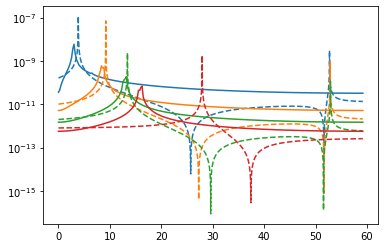

In [45]:
theta = np.zeros(5)
B = np.zeros(P.shape[0])
A = np.zeros((P.shape[0], len(theta)))
pos_f_P = f_P[:len(f_P)//2]
ff_P = np.hstack((pos_f_P, pos_f_P))
 
f_cont = np.linspace(0, pos_f_P[-1], 4000)
H = np.zeros((len(f_cont), P.shape[1]), dtype=complex)

for mode in range(total_mode_num):
    B = np.hstack((P[:len(pos_f_P), mode].real,
                   P[:len(pos_f_P), mode].imag))
    A = np.vstack((-B*np.exp(2*np.pi*ff_P*d_t),
                   -B*np.exp(4*np.pi*ff_P*d_t),
                   np.ones(len(B)),
                   np.exp(2*np.pi*ff_P*d_t),
                   np.exp(4*np.pi*ff_P*d_t))).T
    
    theta = np.linalg.lstsq(A, B, rcond=None)[0]
    resid = np.linalg.lstsq(A, B, rcond=None)[1]
    
    H[:, mode] = (theta[2] +
                  theta[3]*np.exp(2*np.pi*f_cont*d_t) +
                  theta[4]*np.exp(4*np.pi*f_cont*d_t)
                  ) / \
                 (1 +
                  theta[0]*np.exp(2*np.pi*f_cont*d_t) +
                  theta[1]*np.exp(4*np.pi*f_cont*d_t)
                  )

    plt.semilogy(f_P[:len(f_P)//2], abs(P[:len(f_P)//2, mode]), color=colors[mode])
    plt.semilogy(f_cont, abs(H[:, mode]), color=colors[mode], linestyle='--')

### Estimación mediante cuadrado de la FRF

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply


(4.823446312814109e-12, 4.982909806401011e-05)

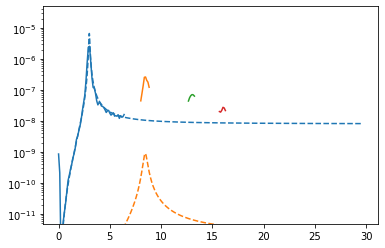

In [46]:
mac_th = 0.9

x = np.zeros(3, dtype=complex)
f = f_S
f_cfdd = np.zeros(total_mode_num)
xi_cfdd = np.zeros(total_mode_num)

f_hat = np.linspace(0, f[len(f)//2-1], 4000)
w_hat = 2*np.pi*f_hat
psd_hat = np.zeros((w_hat.size, total_mode_num), dtype=complex)

for mode in range(total_mode_num):
    peak_idx = mode_ind_fdd[mode]
    idx_low, idx_high = get_efdd_segment(u, peak_idx, mac_th)
    w = 2*np.pi*f[idx_low:idx_high]
    B = s[idx_low:idx_high, mode]
    A = np.vstack((w**4, -B*w**4, -B*w**2)).T    
    x = np.linalg.lstsq(A, B, rcond=None)[0]
    
    w_n = 1/x[1]**0.25
    f_cfdd[mode] = w_n/2/np.pi
    c = np.sqrt(x[0]*w_n**4)
    xi_cfdd[mode] = np.sqrt(abs(x[2]*w_n**2 + 2)/4)
    psd_hat[:, mode] = c**2 * w_hat**4 / \
                       ((w_n**2 - w_hat**2)**2 + 4*xi_cfdd[mode]**2 * w_n**2 * w_hat**2)
    
    plt.semilogy(f[idx_low:idx_high],
                 abs(s[idx_low:idx_high, 0]),
                 color=colors[mode])
    plt.semilogy(f_hat[:f_hat.size//2],
                 abs(psd_hat[:f_hat.size//2, mode]),
                 color=colors[mode],
                 linestyle='--')

plt.ylim([abs(psd_hat[len(f_hat)//4, 1]), None])

In [47]:
err_f_cfdd = (f_cfdd - f_modes)/f_modes*100

data = np.vstack((mode_num, f_modes, f_fdd, f_efdd, f_cfdd)).T
headers = ['Modo', 'Teoría [Hz]', 'FDD [Hz]', 'EFDD [Hz]', 'CFDD [Hz]']
print_modes_dataframe(data=data, headers=headers, decimals=2)

,Modo,Teoría [Hz],FDD [Hz],EFDD [Hz],CFDD [Hz]
0,1,2.95,3.02,3.05,3.00
1,2,8.50,8.48,8.67,8.45
2,3,13.02,13.02,13.29,nan
3,4,15.97,16.04,16.00,inf


In [48]:
data = np.vstack((mode_num, Xi, xi_efdd, xi_cfdd)).T
headers = ['Modo', 'Teoría', 'EFDD', 'CFDD']
print_modes_dataframe(data=data, headers=headers, decimals=3)

,Modo,Teoría,EFDD,CFDD
0,1,0.025,0.048,0.017
1,2,0.025,0.016,0.025
2,3,0.025,0.008,nan
3,4,0.025,0.006,nan
